<a href="https://colab.research.google.com/github/pratikiiitb2013/EVA4/blob/master/Session6/EVA4S6_CODE2_%2B_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTS**

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

**DEFINE TEST/TRAIN TRANSFORMATIONS**

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([ 
                                       transforms.RandomRotation((-4.0, 4.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


**LOAD MNIST DATA**

In [0]:
train = datasets.MNIST('./data', train=True, transform=train_transforms, download=True)
test = datasets.MNIST('./data',train=False, transform=test_transforms, download=True)


**DATA LOADERS**

In [0]:
SEED = 1
np.random.seed(42)
torch.manual_seed(1)

#check for cuda
cuda = torch.cuda.is_available()
print('cuda available', cuda)

if cuda:
  torch.cuda.manual_seed(1)

#dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

#test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

cuda available True


**Data Stats**

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


**MODEL**

In [0]:
class Net(nn.Module):
     def __init__(self):
       super(Net, self).__init__()
       #Input block
       self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(0.05)
       ) # output_size = 26

       #CONV BLOCK 1
       self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU(),   
            nn.Dropout(0.05)
       ) # output_size = 26

       #TRANSITION BLOCK
       self.pool1 = nn.MaxPool2d((2,2))  #out = 13
       self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1,1),padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05)
       ) #output = 13

       #CONV BLOCK 2
       self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU(),
            nn.Dropout(0.05)
       ) # output_size = 11

       self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3,3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.1)
       ) #out = 11

       self.pool2 = nn.MaxPool2d((2,2)) #out = 5
       self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(0.1)
       ) #out = 5

       self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

       self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1,1), padding=0, bias=False)
            #nn.Linear(20,out_features=10)
        )

     def forward(self, x):
       x = self.convblock1(x)
       x = self.convblock2(x)
       #x = self.convblock3(x)
       x = self.pool1(x)
       x = self.convblock4(x)
       x = self.convblock5(x)
       x = self.convblock6(x)
       x = self.pool2(x)
       x = self.convblock7(x)
       #x = self.convblock71(x)
       #x = self.convblock8(x)
       x = self.gap(x)
       x = self.convblock9(x)
       x = x.view(-1, 10)
       return F.log_softmax(x, dim=-1)

In [0]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 14, 26, 26]           1,512
       BatchNorm2d-6           [-1, 14, 26, 26]              28
              ReLU-7           [-1, 14, 26, 26]               0
           Dropout-8           [-1, 14, 26, 26]               0
         MaxPool2d-9           [-1, 14, 13, 13]               0
           Conv2d-10           [-1, 10, 13, 13]             140
      BatchNorm2d-11           [-1, 10, 13, 13]              20
             ReLU-12           [-1, 10, 13, 13]               0
          Dropout-13           [-1, 10, 13, 13]               0
           Conv2d-14           [-1

**Define Train/Test functions with loss and accuracy calculations**

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

**Training the MODEL with validation accuracy check**

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=11, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()
    print('')    

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.037674084305763245 Batch_id=937 Accuracy=94.89: 100%|██████████| 938/938 [00:18<00:00, 51.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9852/10000 (98.52%)


EPOCH: 1


Loss=0.02180001139640808 Batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [00:19<00:00, 49.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9903/10000 (99.03%)


EPOCH: 2


Loss=0.20204788446426392 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:17<00:00, 52.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9881/10000 (98.81%)


EPOCH: 3


Loss=0.008107930421829224 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:18<00:00, 51.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9932/10000 (99.32%)


EPOCH: 4


Loss=0.01287601888179779 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:18<00:00, 50.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9908/10000 (99.08%)


EPOCH: 5


Loss=0.0635627806186676 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:18<00:00, 51.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9924/10000 (99.24%)


EPOCH: 6


Loss=0.006541848182678223 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:17<00:00, 53.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9902/10000 (99.02%)


EPOCH: 7


Loss=0.019833505153656006 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:18<00:00, 51.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9913/10000 (99.13%)


EPOCH: 8


Loss=0.017033100128173828 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:17<00:00, 52.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9918/10000 (99.18%)


EPOCH: 9


Loss=0.003822341561317444 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:18<00:00, 51.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9936/10000 (99.36%)


EPOCH: 10


Loss=0.06874154508113861 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:18<00:00, 50.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9907/10000 (99.07%)


EPOCH: 11


Loss=0.0018555521965026855 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:18<00:00, 51.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9949/10000 (99.49%)


EPOCH: 12


Loss=0.028521493077278137 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:18<00:00, 51.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9946/10000 (99.46%)


EPOCH: 13


Loss=0.010306328535079956 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:18<00:00, 50.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)


EPOCH: 14


Loss=0.0029596686363220215 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:17<00:00, 52.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9951/10000 (99.51%)


EPOCH: 15


Loss=0.008806034922599792 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:18<00:00, 51.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9949/10000 (99.49%)


EPOCH: 16


Loss=0.006896421313285828 Batch_id=937 Accuracy=99.35: 100%|██████████| 938/938 [00:18<00:00, 51.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9954/10000 (99.54%)


EPOCH: 17


Loss=0.06188496947288513 Batch_id=937 Accuracy=99.35: 100%|██████████| 938/938 [00:18<00:00, 52.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9953/10000 (99.53%)


EPOCH: 18


Loss=0.028464458882808685 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:18<00:00, 51.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 9960/10000 (99.60%)


EPOCH: 19


Loss=0.007097259163856506 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:18<00:00, 50.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9954/10000 (99.54%)


EPOCH: 20


Loss=0.02113071084022522 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [00:18<00:00, 51.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9951/10000 (99.51%)


EPOCH: 21


Loss=0.0007341504096984863 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [00:18<00:00, 52.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9949/10000 (99.49%)


EPOCH: 22


Loss=0.002106964588165283 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:18<00:00, 50.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9954/10000 (99.54%)


EPOCH: 23


Loss=0.08078597486019135 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:18<00:00, 51.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 9958/10000 (99.58%)


EPOCH: 24


Loss=0.0037519335746765137 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:17<00:00, 62.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9958/10000 (99.58%)


EPOCH: 25


Loss=0.014022201299667358 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [00:18<00:00, 51.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9953/10000 (99.53%)


EPOCH: 26


Loss=0.0306282639503479 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [00:18<00:00, 51.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9956/10000 (99.56%)


EPOCH: 27


Loss=0.003949835896492004 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [00:18<00:00, 51.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9956/10000 (99.56%)


EPOCH: 28


Loss=0.004835113883018494 Batch_id=937 Accuracy=99.42: 100%|██████████| 938/938 [00:18<00:00, 50.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 9959/10000 (99.59%)


EPOCH: 29


Loss=0.010809659957885742 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [00:18<00:00, 51.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9958/10000 (99.58%)


EPOCH: 30


Loss=0.01807977259159088 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:18<00:00, 50.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9958/10000 (99.58%)


EPOCH: 31


Loss=0.017577633261680603 Batch_id=937 Accuracy=99.42: 100%|██████████| 938/938 [00:18<00:00, 51.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9959/10000 (99.59%)


EPOCH: 32


Loss=0.0030869990587234497 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:18<00:00, 52.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9956/10000 (99.56%)


EPOCH: 33


Loss=0.01061597466468811 Batch_id=937 Accuracy=99.41: 100%|██████████| 938/938 [00:18<00:00, 51.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9955/10000 (99.55%)


EPOCH: 34


Loss=0.020093530416488647 Batch_id=937 Accuracy=99.44: 100%|██████████| 938/938 [00:18<00:00, 50.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9954/10000 (99.54%)


EPOCH: 35


Loss=0.0625045895576477 Batch_id=937 Accuracy=99.42: 100%|██████████| 938/938 [00:18<00:00, 51.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9958/10000 (99.58%)


EPOCH: 36


Loss=0.0189419686794281 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [00:18<00:00, 51.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9960/10000 (99.60%)


EPOCH: 37


Loss=0.04364985227584839 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:18<00:00, 51.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9949/10000 (99.49%)


EPOCH: 38


Loss=0.003722071647644043 Batch_id=937 Accuracy=99.44: 100%|██████████| 938/938 [00:18<00:00, 51.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9958/10000 (99.58%)


EPOCH: 39


Loss=0.05685555934906006 Batch_id=937 Accuracy=99.43: 100%|██████████| 938/938 [00:18<00:00, 50.65it/s]



Test set: Average loss: 0.0156, Accuracy: 9953/10000 (99.53%)




Text(0.5, 1.0, 'Test Accuracy')

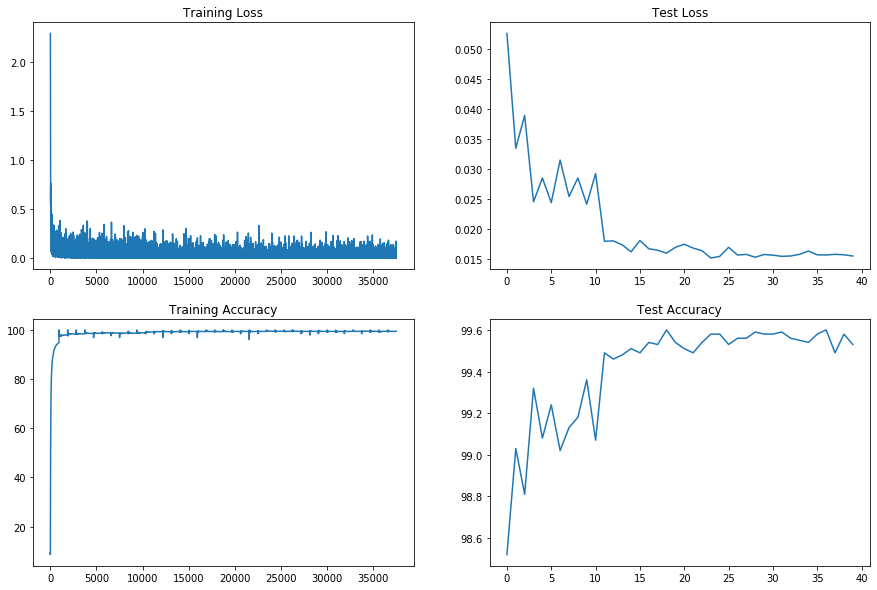

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
import matplotlib.pyplot as plt

def test_misclassified(model, device, test_loader, nimage = 25):
    model.eval()
    images = []
    preds = []
    actual = []
    #test_loss = 0
    #correct = 0
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True).view_as(target)  # get the index of the max log-probability
            #correct += pred.eq(target.view_as(pred)).sum().item()
            for a,b,c in zip(data, target, pred):
              if b!=c:
                a = a.cpu().numpy()
                b = b.cpu().numpy()
                c = c.cpu().numpy()
                a = (a*0.3081)+0.1307
                images.append(a)
                preds.append(c)
                actual.append(b)
                count += 1
              if count == nimage:
                return images, actual, preds

In [0]:
def plot_images(images,actual,preds,nimage=25):
  fig = plt.figure(figsize=(15,18))
  for i in range(nimage):
    ax = fig.add_subplot(5,5,i+1)
    ax.imshow(np.rollaxis(images[i],0,3).squeeze(),cmap='gray')
    #ax.axis('off')
    ax.set_title("Actual: " + str(actual[i]) + " predicted:  " + str(preds[i]))
  plt.show()

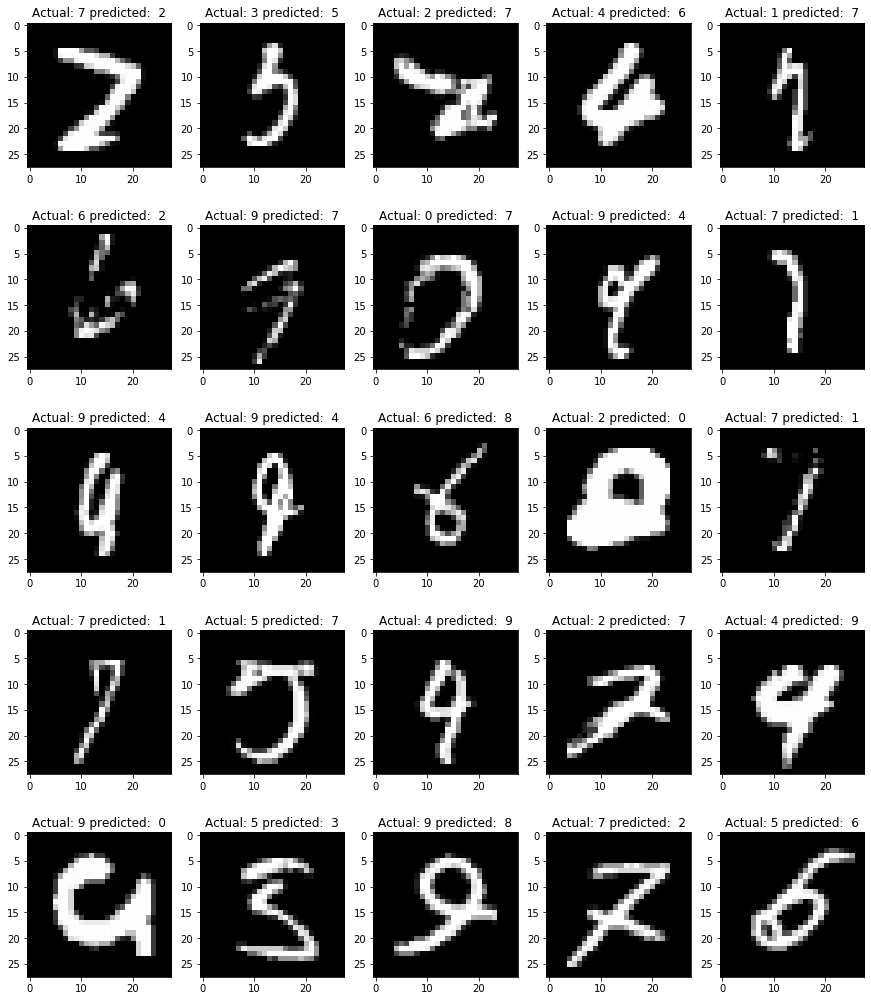

In [0]:
images, actuals, preds = test_misclassified(model,device,test_loader)
plot_images(images,actuals,preds)

In [0]:
test_losses

[0.052508075308799744,
 0.03345730826854706,
 0.03889703938961029,
 0.024563658142089845,
 0.028511730742454527,
 0.02442500693798065,
 0.031488150882720944,
 0.025444161653518677,
 0.028513940596580505,
 0.02417308053970337,
 0.029250298070907593,
 0.018021013832092286,
 0.018065582847595216,
 0.017420833325386048,
 0.016255628514289855,
 0.018138826763629913,
 0.016769290554523468,
 0.01652405891418457,
 0.016031511807441712,
 0.017012686562538147,
 0.01751996147632599,
 0.016880241179466248,
 0.016444201052188873,
 0.015224508547782898,
 0.015507036471366883,
 0.01701075575351715,
 0.015726862943172455,
 0.015829627203941345,
 0.015360989463329314,
 0.015815583062171935,
 0.01570673050880432,
 0.015506615710258484,
 0.015570204412937164,
 0.015844723117351533,
 0.01639365439414978,
 0.015752777528762817,
 0.015737848925590516,
 0.015842460441589355,
 0.015773168325424195,
 0.015561237275600433]

In [0]:
test_acc

[98.52,
 99.03,
 98.81,
 99.32,
 99.08,
 99.24,
 99.02,
 99.13,
 99.18,
 99.36,
 99.07,
 99.49,
 99.46,
 99.48,
 99.51,
 99.49,
 99.54,
 99.53,
 99.6,
 99.54,
 99.51,
 99.49,
 99.54,
 99.58,
 99.58,
 99.53,
 99.56,
 99.56,
 99.59,
 99.58,
 99.58,
 99.59,
 99.56,
 99.55,
 99.54,
 99.58,
 99.6,
 99.49,
 99.58,
 99.53]

In [0]:
test_acc

[98.52,
 99.03,
 98.81,
 99.32,
 99.08,
 99.24,
 99.02,
 99.13,
 99.18,
 99.36,
 99.07,
 99.49,
 99.46,
 99.48,
 99.51,
 99.49,
 99.54,
 99.53,
 99.6,
 99.54,
 99.51,
 99.49,
 99.54,
 99.58,
 99.58,
 99.53,
 99.56,
 99.56,
 99.59,
 99.58,
 99.58,
 99.59,
 99.56,
 99.55,
 99.54,
 99.58,
 99.6,
 99.49,
 99.58,
 99.53]